# Word Embeddings

In this part of the assignment, we'll explore a few properties of word embeddings. We'll use pre-trained GloVe ([Pennington et al. 2013](https://nlp.stanford.edu/pubs/glove.pdf)) embeddings, and evaluate on the analogy task described in ([Mikolov et al. 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)).

If you haven't seen the [embeddings.ipynb](../../materials/embeddings/embeddings.ipynb) demo notebook, we recommend you look through it; this part of the assignment will build on that material.

In [1]:
# Install a few python packages using pip
from w266_common import utils
utils.require_package("wget")      # for fetching dataset

In [2]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse

# NLTK for NLP utils
import nltk

# Helper libraries
from w266_common import utils, vocabulary, tf_embed_viz

# Fits like a GloVe

Word embeddings take a long time to train - since the goal is to provide a good representation for as many words as possible, generating good embeddings often requires making several passes over a very large corpus. 

Fortunately, it's possible to learn fairly general embeddings from large corpora that are useful for many downstream tasks. We'll use the GloVe vectors available at https://nlp.stanford.edu/projects/glove/ - specifically, a set trained with a vocabulary of 400,000 on a corpus of 6B tokens from Wikipedia and Gigaword.

The vectors are distributed as a (very) large text file, with one word per line followed by its vector:
```
the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459
```

We've implemented a helper class, `Hands` in `glove_helper.py`, that will parse these files in a memory efficient manner and provide a wrapper object over a NumPy array containing the actual vectors. 

Run the cell below; the first time, it will download an ~800 MB file to the `data/` directory. **_PLEASE DO NOT CHECK THIS DATA DIRECTORY IN TO GIT!_**

In [3]:
import glove_helper; reload(glove_helper)

hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


`hands` has a few properties and methods that might be useful:
- `hands.vocab` is a `vocabulary.Vocabulary` object that manages the set of available words
- `hands.W` is a matrix of shape $|V| \times d$ containing the actual vectors, one per row. Row indices are as given by `hands.vocab.word_to_id[word]`.
- `hands.get_vector(word)` returns the vector for a word (passed as a string).

Note that we let $|V| = $`hands.W.shape[0]`, which in addition to the actual words includes three special tokens: `<s>` (begin sentence), `</s>` (end sentence), and `<unk>` (unknown word).

In [4]:
k=10
v = hands.get_vector("the")
v_transpose = np.transpose(v)
Wv = hands.W
Wv_transpose = np.transpose(Wv)

cos_sim = np.dot(v, Wv_transpose)/(np.linalg.norm(v)*np.linalg.norm(Wv))
nns = np.argsort(cos_sim)[-1*k:]
nns = nns[::-1]
nns

array([ 3, 50,  6, 32, 47, 12, 16, 40, 15, 23])

In [5]:
ds = cos_sim[nns]
ds

array([0.00225531, 0.00210015, 0.00203196, 0.00203105, 0.00199603,
       0.00197654, 0.00195495, 0.00194346, 0.00193945, 0.00191556],
      dtype=float32)

# Part (a): Nearest Neighbors

### Cosine Similarity

To measure the similarity of two words, we'll use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between their representation vectors:

$$ D^{cos}_{ij} = \frac{v_i^T v_j}{||v_i||\ ||v_j||}$$

*Note that this is called cosine similarity because $D^{cos}_{ij} = \cos(\theta_{ij})$, where $\theta_{ij}$ is the angle between the two vectors.*

## Part (a) Questions

1. In `vector_math.py`, implement the `find_nn_cos(...)` function. Read the docstring _carefully_ - it describes what you should return. *Hint: use NumPy functions instead of a `for` loop.*
<p>
2. Use the `show_nns(...)` function below to find the nearest neighbors for the words `"bank"`, `"plane"`, and `"flies"`. Put the closest word (other than *the exact word* itself) in the answers file.  If you inspect `"flies"`, for instance, are the neighbors dominated by one sense of the word or is there evidence that the vector encodes meaning of the other senses as well?
<p>
3. Like `word2vec`, GloVe constructs representations by summarizing word-word coocurrence statistics. Use `show_nns(...)` to find the neighbors of `"green"` and `"celadon"`, and `"orange"`. Explain what you find in terms of the distributional hypothesis and the grounding problem. Does the vector for `"celadon"` appear to encode a notion of color? What do they represent, instead?

_(The Distributional Hypothesis is the idea that "you shall know a word by the company it keeps" (Firth, 1957) - that meaning is derived from the context in which a word is used. Grounding refers to the meaning of language in terms of external concepts, such as real-world entities or physical characteristics.  Take a look at the readings from the first week if you're not confident.)_


In [6]:
import vector_math; reload(vector_math)

def show_nns(hands, word, k=10):
    """Helper function to print neighbors of a given word."""
    word = word.lower()
    print("Nearest neighbors for '{:s}'".format(word))
    v = hands.get_vector(word)
    for i, sim in zip(*vector_math.find_nn_cos(v, hands.W, k)):
        target_word = hands.vocab.id_to_word[i]
        print("{:.03f} : '{:s}'".format(sim, target_word))
    print("")
    
show_nns(hands, "the")

Nearest neighbors for 'the'
0.002 : 'the'
0.002 : 'its'
0.002 : 'of'
0.002 : 'an'
0.002 : 'their'
0.002 : ''s'
0.002 : 'on'
0.002 : 'this'
0.002 : 'that'
0.002 : 'it'



In [7]:
#### YOUR CODE HERE ####
# Code for Part (a).2

show_nns(hands, "bank")
show_nns(hands, "plane")
show_nns(hands, "flies")

#### END(YOUR CODE) ####

Nearest neighbors for 'bank'
0.003 : 'bank'
0.002 : 'banks'
0.002 : 'securities'
0.002 : 'banking'
0.002 : 'investment'
0.002 : 'financial'
0.002 : 'capital'
0.002 : 'billion'
0.002 : 'credit'
0.002 : 'loans'

Nearest neighbors for 'plane'
0.002 : 'plane'
0.002 : 'flight'
0.002 : 'aircraft'
0.002 : 'planes'
0.002 : 'jet'
0.002 : 'crashed'
0.002 : 'airliner'
0.002 : 'helicopter'
0.002 : 'crash'
0.002 : 'airplane'

Nearest neighbors for 'flies'
0.002 : 'flies'
0.002 : 'fly'
0.002 : 'insects'
0.002 : 'moth'
0.002 : 'moths'
0.001 : 'plane'
0.001 : 'birds'
0.001 : 'planes'
0.001 : 'species'
0.001 : 'flying'



In [8]:
#### YOUR CODE HERE ####
# Code for Part (a).3

show_nns(hands, "green")
show_nns(hands, "celadon")
show_nns(hands, "orange")

#### END(YOUR CODE) ####

Nearest neighbors for 'green'
0.002 : 'green'
0.002 : 'red'
0.002 : 'white'
0.002 : 'blue'
0.002 : 'yellow'
0.002 : 'black'
0.002 : 'brown'
0.002 : 'pink'
0.002 : 'orange'
0.002 : 'dark'

Nearest neighbors for 'celadon'
0.002 : 'celadon'
0.001 : 'porcelain'
0.001 : 'earthenware'
0.001 : 'faience'
0.001 : 'balsamic'
0.001 : 'unglazed'
0.001 : 'glazes'
0.001 : 'glazed'
0.001 : 'porcelains'
0.001 : 'pottery'

Nearest neighbors for 'orange'
0.002 : 'orange'
0.002 : 'yellow'
0.002 : 'blue'
0.002 : 'red'
0.002 : 'green'
0.002 : 'black'
0.001 : 'lemon'
0.001 : 'pink'
0.001 : 'white'
0.001 : 'cream'



# Part (b): Linear Analogies

In this part, you'll implement the word analogy task described in Section 4 of ([Mikolov et al. 2013](https://arxiv.org/pdf/1301.3781.pdf)), and discussed in section 4.8 and 4.11 of the async.

1. In `vector_math.py`, implement the `analogy(...)` function. (*Hint: this should be a very short function, given what you've already written above.*)
<p>

2. Evaluate the following analogies:
<ul>
<li> `"mouse" is to "mice" as "dog" is to ____`
<li> `"fast" is to  "fastest"   as "slow" is to ____`
<li> `"work" is to  "works"   as "speak" is to ____`
<li> `"russia" is to  "moscow"   as "greece" is to ____`
</ul>

<p>

3. (Ungraded) Play with a few analogies using the `show_analogy(...)` function below. Concretely, see if you can find at least one more analogy that tests each of the following relationships, and that the model gets right:<ul>
<li> Singular / plural
<li> Superlatives
<li> Verb tense
<li> Country / capital
</ul>

(See Table 1 of [Mikolov et al. 2013](https://arxiv.org/pdf/1301.3781.pdf) for a few ideas)

<p>

4. Evaluate the following analogies:
<ul>
<li> `"lizard" is to "reptile" as "dog" is to ____`
<li> `"finger" is to  "hand"   as "toe" is to ____`
</ul>


Similar to before, report the closest word (highest scoring) and exclude any exact match to any of the three words in the analogy query.

Think about what types of relations do these test? Does our approach of linear analogies work well here? What assumption is violated by these sorts of relationships? (_Hint: what if we reversed the order, and tested "reptile" is to "lizard", and so on?_ See [Meronymy](https://en.wikipedia.org/wiki/Meronymy).)

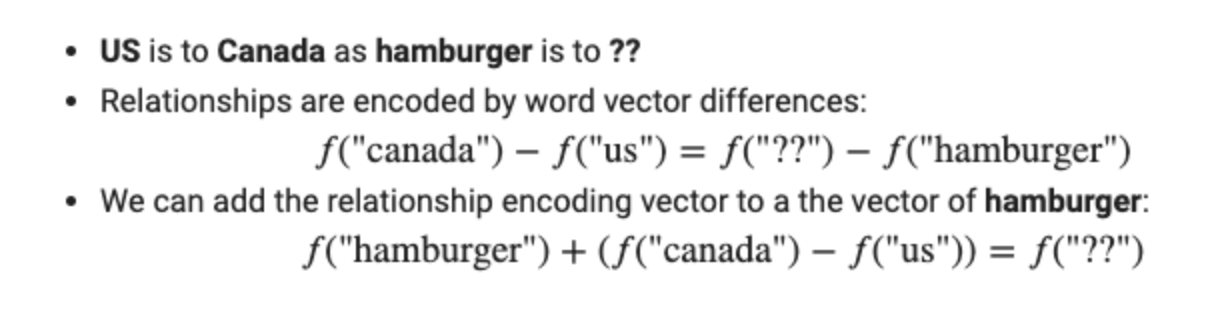

In [9]:
import vector_math; reload(vector_math)

def show_analogy(hands, a, b, c, k=5):
    """Compute and print a vector analogy."""
    a, b, c = a.lower(), b.lower(), c.lower()
    va = hands.get_vector(a)
    vb = hands.get_vector(b)
    vc = hands.get_vector(c)
    print("'{a:s}' is to '{b:s}' as '{c:s}' is to ___".format(**locals()))
    for i, sim in zip(*vector_math.analogy(va, vb, vc, hands.W, k)):
        target_word = hands.vocab.id_to_word[i]
        print("{:.03f} : '{:s}'".format(sim, target_word))
    print("")
    
show_analogy(hands, "king", "queen", "man")

'king' is to 'queen' as 'man' is to ___
0.002 : 'woman'
0.002 : 'her'
0.002 : 'man'
0.002 : 'she'
0.002 : 'girl'



In [10]:
#### YOUR CODE HERE ####
# Code for Part (b).2

show_analogy(hands, "mouse", "mice", "dog")
show_analogy(hands, "fast", "fastest", "slow")
show_analogy(hands, "work", "works", "speak")
show_analogy(hands, "russia", "moscow", "greece")

#### END(YOUR CODE) ####

'mouse' is to 'mice' as 'dog' is to ___
0.002 : 'dogs'
0.002 : 'mice'
0.002 : 'animals'
0.002 : 'dog'
0.002 : 'rats'

'fast' is to 'fastest' as 'slow' is to ___
0.002 : 'fastest'
0.002 : 'slowest'
0.001 : 'growth'
0.001 : 'fourth'
0.001 : 'quarter'

'work' is to 'works' as 'speak' is to ___
0.002 : 'speak'
0.002 : 'languages'
0.002 : 'language'
0.001 : 'spoken'
0.001 : 'speaks'

'russia' is to 'moscow' as 'greece' is to ___
0.002 : 'athens'
0.002 : 'greece'
0.002 : 'moscow'
0.002 : 'greek'
0.001 : 'istanbul'



In [11]:
#### YOUR CODE HERE ####
# Code for Part (b).3

show_analogy(hands, "lizard", "reptile", "dog")
show_analogy(hands, "finger", "hand", "toe")

#### END(YOUR CODE) ####

'lizard' is to 'reptile' as 'dog' is to ___
0.002 : 'dog'
0.001 : 'dogs'
0.001 : 'pet'
0.001 : 'animal'
0.001 : 'animals'

'finger' is to 'hand' as 'toe' is to ___
0.002 : 'toe'
0.001 : '-'
0.001 : 'knee'
0.001 : 'shoes'
0.001 : 'wearing'

